In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=

env: CUDA_VISIBLE_DEVICES=


In [2]:
import sys

sys.path.append("../")

In [14]:
import fof.dataloader
import transformers as tr
from pathlib import Path
import torchvision

In [37]:
loader = fof.dataloader.ScicapDataModule(
  "First-Sentence",
  tokenizer=tr.AutoTokenizer.from_pretrained("distilbert-base-uncased"),
  root=Path("../scicap_data"),
  batch_size=1,
  caption_type="orig",
  num_workers=0, transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
  ]))
test = loader.test_dataloader()

Initializing SCICAP training dataset
Initializing SCICAP testing dataset
Initializing SCICAP validation dataset
Time taken: 0.05723071098327637


In [42]:
batch = next(iter(test))
len(batch["figure"])

1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


references ghlights
the importance of pseudorandomness in CFO.

Fig. 6. Evolution of GP Function Best Fitness

Fig. 7 plots CFO's " Davg curve" for GP. Davg is the normalized average distance
between the probe with th
labels Fig. 7. Evolution of GP Function avgD
title Pseudorandomness in Central Force Optimization
id 1001.0317v2-Figure7-1.png
abstract   Central Force Optimization is a deterministic metaheuristic for an
evolutionary algorithm that searches a decision space by flying probes whose
trajectories are computed using a gravitational metaphor. CFO benefits
substantially from the inclusion of a pseudorandom component (a numerical
sequence that is precisely known by specification or calculation but otherwise
arbitrary). The essential requirement is that the sequence is uncorrelated with
the decision space topology, so that its effect is to pseudorandomly distribute
probes throughout the landscape. While this process may appear to be similar to
the randomness in an inherently stoc

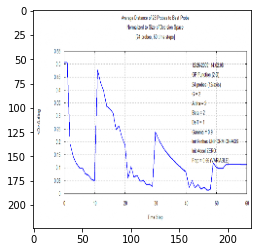

In [43]:
for key in ["references", "labels", "title", "id", "abstract"]:
    print(key, batch[key][0])

import matplotlib.pyplot as plt
plt.imshow(batch["figure"][0].permute(1, 2, 0) / 255)

In [44]:
from fof.encdec import EncoderDecoderModel
from fof.dataloader import ScicapDataModule
from pathlib import Path
import wandb
run = wandb.init(project="figuring-out-figures")


In [45]:
def load_model(artifact_str: str = None, ckpt_path: str = None):
    if artifact_str is not None:
        artifact = run.use_artifact(artifact_str, type="model")
        artifact_dir = artifact.download()
        ckpt_path = Path(artifact_dir) / "model.ckpt"
    model = EncoderDecoderModel.load_from_checkpoint(ckpt_path)
    return model


model = load_model(
    "figuring-out-figures/figuring-out-figures/model-27py12gz:v1")


wandb: Downloading large artifact model-27py12gz:v1, 2532.30MB. 1 files... Done. 0:0:0
Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.2.self_attn.v_proj.weight', 'text_model.encoder.layers.5.self_attn.q_proj.weight', 'text_model.encoder.layers.9.self_attn.out_proj.weight', 'text_model.encoder.layers.4.mlp.fc1.bias', 'text_model.encoder.layers.11.mlp.fc1.weight', 'text_model.encoder.layers.2.layer_norm2.weight', 'text_model.encoder.layers.1.self_attn.k_proj.weight', 'text_model.encoder.layers.11.layer_norm1.bias', 'text_model.encoder.layers.7.self_attn.out_proj.weight', 'text_model.encoder.layers.5.layer_norm1.weight', 'text_model.encoder.layers.0.mlp.fc2.bias', 'text_model.encoder.layers.7.layer_norm1.bias', 'text_model.encoder.layers.4.self_attn.v_proj.weight', 'text_model.encoder.layers.9.layer_norm1.bias', 'text_model.encoder.layers.3.mlp.fc1.bias', 'text_model.encoder.layers.8.self_at

In [46]:
model.run_sampling_batch(*model.process_batch(batch))

(['Fig. 7. Evolution of Fitness for Pareto Front with GP.'],
 ['Fig. 7. Evolution of GP Function avgD'])